In [85]:
# Copyright 2023 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# LCMS Model Setup

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibration.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/redcastle-resources/lcms-training/blob/main/5.1-Model_Calibrationp.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>
<br/><br/><br/>

## Overview


This notebook takes the prepared model calibration featureCollection assets from Module 4, downloads them, sets up LCMS models for Change, Land Cover, and Land Use using scikit-learn, evaluates them, and removes correlated predictor variables.


### Objective

In this tutorial, you learn how to download data from GEE to use be able to set up models using packages from scikit-learn 

This tutorial uses the following Google Cloud services:

- `Google Earth Engine`

The steps performed include:

- Bringing in annual exported training data from Module 4
- Downloading these data to a local location
- Identifying highly correlated predictor variables
- Setting up random forest models for Change, Land Cover, and Land Use and evaluating their accuracy and variable importance

In [376]:
#Module imports
#!python -m pip install geeViz --upgrade

try:
    import geeViz.getImagesLib as getImagesLib
except:
    !python -m pip install geeViz
    import geeViz.getImagesLib as getImagesLib

import geeViz.changeDetectionLib as changeDetectionLib
import geeViz.assetManagerLib as aml
import geeViz.taskManagerLib as tml
import geeViz.gee2Pandas as g2p


try:
    import pandas as pd
except:
    !pip install matplotlib
    import pandas as pd

try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,cohen_kappa_score
    from sklearn import metrics 
except:
    !pip install -U scikit-learn
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score,classification_report,balanced_accuracy_score,cohen_kappa_score
    from sklearn import metrics 
import numpy as np
import os,json
try:
    import seaborn
except:
    !python -m pip install seaborn
    import seaborn
    
ee = getImagesLib.ee
Map = getImagesLib.Map

# Can set the port used for viewing map outputs
Map.port = 1234
print('Done')


Done


## Before you begin

### Set your current URL under `workbench_url`
* This will be in your URL/search bar at the top of the browser window you are currently in
* It will look something like `https://1234567890122-dot-us-west3.notebooks.googleusercontent.com/`

### Set a folder to use for all exports under `export_path_root` 
* It will be something like `projects/projectID/assets/someFolder`
* This folder does not have to already exist. If it does not exist, it will be created

In [192]:
workbench_url = 'https://53c21733d8125e22-dot-us-west3.notebooks.googleusercontent.com'
export_path_root  = 'projects/rcr-gee/assets/lcms-training'

print('Done')

Done


In [193]:
# Bring in all folders/collections that are needed
# These must already exist as they are created in previous notebooks
export_timeSync_folder = f'{export_path_root}/lcms-training_module-4_timeSync'

# This is the pre-made TimeSync data
# Creating this dataset is not covered in this set of notebooks
timeSync_featureCollection = 'projects/lcms-292214/assets/R8/PR_USVI/TimeSync/18_PRVI_AllPlots_TimeSync_Annualized_Table_secLC'


# Currently geeView within Colab uses a different project to authenticate through, so you may need to make your asset public to view from within Colab
aml.updateACL(export_timeSync_folder,writers = [],all_users_can_read = True,readers = [])

print('Done')

Updating permissions for:  projects/rcr-gee/assets/lcms-training/lcms-training_module-4_timeSync
Done


In [194]:
Map.proxy_url = workbench_url

# Bring in raw TS data
timeSyncData = ee.FeatureCollection(timeSync_featureCollection)
timeSync_fields = timeSyncData.first().toDictionary().keys().getInfo()
# Now lets bring in all training data and prep it for modeling
assets = ee.data.listAssets({'parent': export_timeSync_folder})['assets']

# You may need to change the permissions for viewing model outputs in geeViz
# Uncomment this if needed
# for asset in assets:aml.updateACL(asset['name'],writers = [],all_users_can_read = True,readers = [])

# Read in each year of extracted TimsSync data
training_data = ee.FeatureCollection([ee.FeatureCollection(asset['name']) for asset in assets]).flatten()

# Bring in existing LCMS data for the class names, numbers, and colors
lcms_viz_dict = ee.ImageCollection("USFS/GTAC/LCMS/v2020-6").first().toDictionary().getInfo()
                                             
print('LCMS class code, names, and colors:',lcms_viz_dict)


# Get the field names for prediction
# Find any field that was not in the original TimeSync data and assume that is a predictor variable
all_fields = training_data.first().toDictionary().keys().getInfo()
predictor_field_names = [field for field in all_fields if field not in timeSync_fields]

# Filter out any non null values (any training plot with missing predictor data will cause the model to fail entirely)
training_data = training_data.filter(ee.Filter.notNull(predictor_field_names))




LCMS class code, names, and colors: {'Change_class_names': ['Stable', 'Slow Loss', 'Fast Loss', 'Gain', 'Non-Processing Area Mask'], 'Change_class_palette': ['3d4551', 'f39268', 'd54309', '00a398', '1b1716'], 'Change_class_values': [1, 2, 3, 4, 5], 'Land_Cover_class_names': ['Trees', 'Tall Shrubs & Trees Mix (SEAK Only)', 'Shrubs & Trees Mix', 'Grass/Forb/Herb & Trees Mix', 'Barren & Trees Mix', 'Tall Shrubs (SEAK Only)', 'Shrubs', 'Grass/Forb/Herb & Shrubs Mix', 'Barren & Shrubs Mix', 'Grass/Forb/Herb', 'Barren & Grass/Forb/Herb Mix', 'Barren or Impervious', 'Snow or Ice', 'Water', 'Non-Processing Area Mask'], 'Land_Cover_class_palette': ['005e00', '008000', '00cc00', 'b3ff1a', '99ff99', 'b30088', 'e68a00', 'ffad33', 'ffe0b3', 'ffff00', 'aa7700', 'd3bf9b', 'ffffff', '4780f3', '1b1716'], 'Land_Cover_class_values': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 'Land_Use_class_names': ['Agriculture', 'Developed', 'Forest', 'Non-Forest Wetland', 'Other', 'Rangeland or Pasture', 'No

In [195]:
# Now, we'll crosswalk the training fields to numeric codes
# The TimeSync fields are a string by default
# They must be a number for modeling
# Set up lookup dictionaries to convert the names to numeric codes
land_cover_name_code_dict = ee.Dictionary({'TREES':1,
                             'TSHRUBS-TRE':2,
                             'SHRUBS-TRE':3,
                             'GRASS-TREE':4,
                             'BARREN-TRE':5,
                             'TSHRUBS':6,
                             'SHRUBS':7,
                             'GRASS-SHRU':8,
                             'BARREN-SHR':9,
                             'GRASS':10,
                             'BARREN-GRA':11,
                             'BARREN-IMP':12,
                             'BARREN-IMP':12,
                             'WATER':14
                            })
land_use_name_code_dict = ee.Dictionary({'Agriculture':1,
                           'Developed':2,
                           'Forest':3,
                           'Non-forest Wetland':4,
                           'Other':5,
                           'Rangeland':6
                          })

change_code_dict = ee.Dictionary({'Debris': 3, 
                                  'Fire': 3, 
                                  'Growth/Recovery': 4, 
                                  'Harvest': 3, 'Hydrology': 3, 
                                  'Mechanical': 3, 
                                  'Other': 3, 
                                  'Spectral Decline': 2, 
                                  'Stable': 1, 
                                  'Structural Decline': 2, 
                                  'Wind/Ice': 3})

reference_field_dict = {'Land_Cover':{'field':'DOM_SEC_LC','name_code_dict':land_cover_name_code_dict},
                        'Land_Use':{'field':'DOM_LU','name_code_dict':land_use_name_code_dict},
                        'Change':{'field':'CP','name_code_dict':change_code_dict,
                                  'fields':['Slow Loss', 'Fast Loss', 'Gain']}
                       }
# Make a function that will get the code for a given name and set it
# We could also use the remap function to accomplish this
def set_class_code(plot,product):
    name_fieldName = reference_field_dict[product]['field']
    code_fieldName = ee.String(name_fieldName).cat('_Code')
    name = ee.String(plot.get(name_fieldName))
    code = reference_field_dict[product]['name_code_dict'].get(name)
    plot = plot.set(code_fieldName,code)
    return plot
                    
                    
    # print(name_fieldName,code_fieldName.getInfo(),name.getInfo(),code.getInfo())
            
# set_class_code(training_data.first(),'Land_Cover')
for product in list(reference_field_dict.keys()):
    print('Crosswalking:',product)
    training_data = training_data.map(lambda f:set_class_code(f,product))

# Take a look at the resulting cross-walked table
print('Converted codes first plot:',ee.Feature(training_data.first()).select(['CP','DOM_SEC_LC','DOM_LU','.*_Code']).toDictionary().getInfo())
print('Change class counts:',training_data.aggregate_histogram(reference_field_dict['Change']['field']).getInfo())
print('Land cover class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Cover']['field']).getInfo())
print('Land use class counts:',training_data.aggregate_histogram(reference_field_dict['Land_Use']['field']).getInfo())
print('Done')

Crosswalking: Land_Cover
Crosswalking: Land_Use
Crosswalking: Change
Converted codes first plot: {'CP': 'Stable', 'CP_Code': 1, 'DOM_LU': 'Forest', 'DOM_LU_Code': 3, 'DOM_SEC_LC': 'BARREN-TRE', 'DOM_SEC_LC_Code': 5}
Change class counts: {'Debris': 6, 'Fire': 3, 'Growth/Recovery': 2501, 'Harvest': 88, 'Hydrology': 67, 'Mechanical': 197, 'Other': 10, 'Spectral Decline': 30, 'Stable': 17544, 'Structural Decline': 2, 'Wind/Ice': 543}
Land cover class counts: {'BARREN-GRA': 106, 'BARREN-IMP': 2096, 'BARREN-SHR': 108, 'BARREN-TRE': 47, 'GRASS': 2346, 'GRASS-SHRU': 877, 'GRASS-TREE': 1111, 'SHRUBS': 832, 'SHRUBS-TRE': 764, 'TREES': 12100, 'WATER': 604}
Land use class counts: {'Agriculture': 636, 'Developed': 3810, 'Forest': 11824, 'Non-forest Wetland': 999, 'Other': 815, 'Rangeland': 2907}
Done


In [196]:
# Now will download the training table to a local location

local_model_data_folder = '/tmp/lcms-training/local_modeling'
local_training_csv = os.path.join(local_model_data_folder,'timeSync_training_table.csv')


if not os.path.exists(local_model_data_folder):os.makedirs(local_model_data_folder)

# Download the training data from a featureCollection to a local CSV
# This function will automatically break the featureCollection into 5000 feature featureCollections
# if it is larger than the 5000 feature limit set by GEE
g2p.featureCollection_to_csv(training_data,local_training_csv,overwrite = False)

# Once the table is store locally, read it in
training_df = pd.read_csv(local_training_csv)

training_df.describe()

/tmp/lcms-training/local_modeling/timeSync_training_table.csv  already exists


,BARREN,BARREN-GRA,BARREN-IMP,BARREN-SHR,BARREN-TRE,BARREN-TS,CHANGE_DUR,CP_Code,DOM_LU_Code,DOM_SEC_LC_Code,...,swir2_LT_dur,swir2_LT_fitted,swir2_LT_mag,swir2_LT_slope,wetness_LT_diff,wetness_LT_dur,wetness_LT_fitted,wetness_LT_mag,wetness_LT_slope,year
count,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,20991.0,20991.000000,20991.000000,20991.000000,20991.000000,...,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000,20991.000000
mean,0.0,0.005050,0.099852,0.005145,0.002239,0.0,14.434424,1.446048,3.298604,4.340765,...,26.464866,0.079352,0.005295,0.000475,-0.013667,29.345386,-0.072756,-0.021041,-0.000434,2010.969020
std,0.0,0.070884,0.299810,0.071546,0.047267,0.0,6.677872,1.024257,1.289536,4.450177,...,11.170483,0.040064,0.034007,0.005681,0.029791,10.744572,0.044717,0.042725,0.005656,6.047925
min,0.0,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,0.006793,-0.210283,-0.070094,-0.483630,1.000000,-0.516985,-0.483630,-0.053737,2000.517822
25%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,10.000000,1.000000,3.000000,1.000000,...,17.000000,0.052914,-0.011323,-0.000481,-0.025021,21.000000,-0.096717,-0.039287,-0.001377,2005.906860
50%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,17.000000,1.000000,3.000000,1.000000,...,28.000000,0.069325,0.006184,0.000224,-0.012569,37.000000,-0.065846,-0.021936,-0.000674,2011.208252
75%,0.0,0.000000,0.000000,0.000000,0.000000,0.0,21.000000,1.000000,3.000000,9.000000,...,38.000000,0.095418,0.021533,0.000878,0.000000,38.000000,-0.044558,0.000000,0.000000,2016.167114
max,0.0,1.000000,1.000000,1.000000,1.000000,0.0,21.000000,4.000000,6.000000,14.000000,...,38.000000,0.373654,0.300531,0.204653,0.381094,38.000000,0.072465,0.381094,0.226203,2021.411011


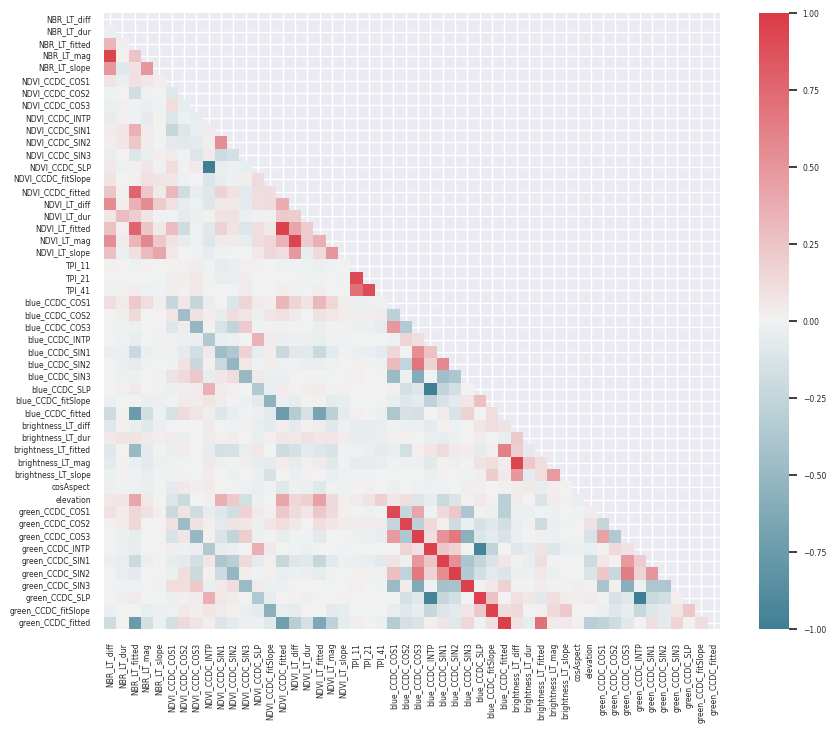

In [197]:
# Once the data are local, we can use the many packages available in Python and even R for data science
# The first step in feature selection (predictor variable selection) 
# LCMS performs is to eliminate extremely correlated predictor variables
# First, we will visualize the correlation of each pair of variables for the first 50 variables
# You can look at all variables, but it is difficult to read the variable name
# The take-home is there are some highly correlated variables that are likely not providing the model much additional information

# Get the correlation matrix for the first 50 variables
corr = training_df[predictor_field_names[:50]].corr()

# Mask out the upper right triangle and the 1:1 diagonal which always has a corr of 1
corr = corr.where(np.tril(np.ones(corr.shape), k=-1).astype(bool))

# Plot the matrix
seaborn.set(font_scale=0.5)
f, ax = plt.subplots(figsize=(10, 8))

corrPlot = seaborn.heatmap(corr,
    cmap=seaborn.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)


In [22]:
# In order to remove correlated variables, we will find pairs with a R2 > 0.95 and take the variable with the lowest average R2

# This is the function LCMS uses
# There are many ways of doing this, but this is a simple way that generally gives a good result
def lcms_corr_drop(x,cut = 0.95):
    # Get independent variables from training data table    
    # x = trainingData[indNames]
    indNames = x.columns
    # # reverse order of columns so that Comp features come first for each index so they will be dropped before LT features when correlated
    # x = x[x.columns[::-1]]

    # Find initial correlation of each feature to the others
    corr_matrix = x.corr().abs()
    # Calculate average correlation score of each variable
    corr_score = [corr_matrix[variable].mean() for variable in indNames]
    corr_score = zip(corr_score,indNames)
    sorted_scores = sorted(corr_score, reverse=True)
    sorted_indNames = [element for _, element in sorted_scores]

    # Redo the correlation matrix with the new order of variable names
    x = x[sorted_indNames]
    corr_matrix = x.corr().abs()
    # corr_matrix.to_csv(os.path.join(correlatedVarsDir, run_name+'_CorrelationMatrix.csv'), index = False)

    # Select lower triangle of correlation matrix
    upper = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(bool)) # numpy error, np.bool is deprecated, changed to bool
    
    # This matrix is ordered in order of correlation score. Use this to check. So we drop in order of correlation score.
    # upper['Average_Scores'] = [pd.concat([upper[varName],upper.loc[varName].transpose()]).mean(skipna=True) for varName in upper.columns]

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > cut)]
    return to_drop

print('Done')

Done


In [23]:
# Find correlated variables to drop and remove them from the predictor field name list
lcms_to_drop = lcms_corr_drop(training_df[predictor_field_names],cut = 0.95)
print('Correlated variables:',lcms_to_drop)

predictor_field_names_no_corr = [var for var in predictor_field_names if var not in lcms_to_drop]

# Save predictor variables for use in next notebook
all_predictors_csv = os.path.join(local_model_data_folder,'all_predictor_field_names.csv')
o = open(all_predictors_csv,'w')
o.write(','.join(predictor_field_names))
o.close()

no_corr_predictors_csv = os.path.join(local_model_data_folder,'no_corr_predictor_field_names.csv')
o = open(no_corr_predictors_csv,'w')
o.write(','.join(predictor_field_names_no_corr))
o.close()

print('Done')

Correlated variables: ['red_CCDC_fitted', 'green_CCDC_fitted', 'NDVI_CCDC_fitted', 'blue_CCDC_SIN1', 'green_CCDC_COS3', 'red_CCDC_INTP', 'blue_CCDC_SIN2', 'green_CCDC_INTP', 'green_CCDC_SLP', 'blue_CCDC_INTP', 'swir1_CCDC_SLP', 'swir2_CCDC_SLP', 'green_CCDC_SIN3', 'NDVI_CCDC_SLP', 'green_CCDC_fitSlope', 'nir_CCDC_SLP']
Done


In [210]:

# Now we will fit RF models and evaluate them using several methods
# This will help us understand the error structure within the model

# Specify the number of trees and a random seed
# Ideally the number of trees is around 150-250 or so, but it will take a long
# time to run the analysis when it's at 150 or so. 50 is generally enough to get a sense of model accuraccy
nTrees = 50
seed = 999

def fit_rf(product_name,predictor_fields,title_prefix='',var_importance_n = 50):
    product_title = product_name.replace('_',' ')
    
    # Pull out the dependent (y) and independent predictors (X)
    X = training_df[predictor_fields]
    y = training_df[reference_field_dict[product_name]['field']+'_Code']
    
    # Split them into a test and train set for further model evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    
    # Set up a random forest model
    rf = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
    
    # First, fit it using all training data
    rf.fit(X,y)
    
    # Get the out-of-bag accuracy 
    # This is generally a good indication of model accuracy
    oob_acc = rf.oob_score_
    print(f'{title_prefix} {product_title} out-of-bag accuracy:',"%.4f" % oob_acc)
    
    # Now let's look at the variable importance
    feature_importances = pd.Series(rf.feature_importances_, index=predictor_fields).sort_values(ascending=True)
    feature_importances.iloc[-var_importance_n:].plot.barh(fontsize=5,title=f'{title_prefix} {product_title} Variable Importance')
    plt.show()
 
    # Now, fit the model using the 80% training subset
    rf.fit(X_train,y_train)
    
    # And then apply it to the 20% test subset
    y_pred = rf.predict(X_test)

    # Find the class names
    class_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    
    # Remove the missing classes in PRUSVI
    if product_name == 'Land_Cover':
        del class_names[1]
        del class_names[4]
        del class_names[-2]
    
    # Get various accuracy metrics
    overall_acc = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    
    # Print info about the model
    print(f'{title_prefix} {product_title} report:')
    print(classification_report(y_test, y_pred, target_names=class_names, digits=4))
    print(f'{title_prefix} {product_title} Overall Accuracy:',"%.4f" % overall_acc)
    print(f'{title_prefix} {product_title} Balanced Accuracy:',"%.4f" % balanced_acc)
    print(f'{title_prefix} {product_title} Kappa:',"%.4f" % kappa)
    
    predictors_by_importance = feature_importances.index.tolist()
    predictors_by_importance.reverse()
    return oob_acc,overall_acc,balanced_acc,kappa,predictors_by_importance
print('Done')

Done


In [ ]:
# Now evaluate models for each LCMS product with various sets of predictor variables
# and create a summary table
product_names = ['Change','Land_Cover','Land_Use']
acc_table = []
for product_name in product_names:
    
    # First fit a model using all predictors
    all_model_info = list(fit_rf(product_name,predictor_field_names,'All Predictors'))
    all_model_info.insert(0,'All Predictors')
    all_model_info.insert(0,product_name)
    acc_table.append(all_model_info)
    
    # Then fit a model using the variables with < 0.95 r-squared
    non_corr_model_info = list(fit_rf(product_name,predictor_field_names_no_corr,'Non-correlated Predictors'))
    non_corr_model_info.insert(0,'Non-correlated Predictors')
    non_corr_model_info.insert(0,product_name)
    acc_table.append(non_corr_model_info)
    
    # Next take only the top 30 predictors regardless of co-variance 
    all_top30_model_info = list(fit_rf(product_name,all_model_info[-1][:30],'Top 30 Var Imp'))
    all_top30_model_info.insert(0,'All Predictors Top 30')
    all_top30_model_info.insert(0,product_name)
    acc_table.append(all_top30_model_info)
    
    # Then take the top 30 with < 0.95 r-squared
    non_corr_top30_model_info = list(fit_rf(product_name,non_corr_model_info[-1][:30],'Non Corr Top 30 Var Imp'))
    non_corr_top30_model_info.insert(0,'Non-correlated Predictors Top 30')
    non_corr_top30_model_info.insert(0,product_name)
    acc_table.append(non_corr_top30_model_info)

print('Done')

In [212]:
model_options_df = pd.DataFrame(acc_table,columns = ['Product Name','Model Name','OOB Acc','Overall Acc','Balanced Acc','Kappa','Var Imp'])
display(model_options_df)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_model_options_table.csv')
model_options_df.to_csv(model_options_csv_filename,index=False)
    
print('Done')

,Product Name,Model Name,OOB Acc,Overall Acc,Balanced Acc,Kappa,Var Imp
0,Change,All Predictors,0.918965,0.917599,0.584399,0.667757,"[year, swir2_LT_fitted, NDVI_CCDC_fitted, wetn..."
1,Change,Non-correlated Predictors,0.919156,0.914980,0.728435,0.669061,"[year, swir2_LT_fitted, NBR_LT_fitted, wetness..."
2,Change,All Predictors Top 30,0.919966,0.911169,0.559660,0.623483,"[year, swir2_LT_slope, swir2_LT_fitted, NDVI_L..."
3,Change,Non-correlated Predictors Top 30,0.926492,0.919028,0.536572,0.682760,"[year, swir2_LT_slope, NDVI_CCDC_INTP, NBR_LT_..."
4,Land_Cover,All Predictors,0.976466,0.973327,0.887540,0.958366,"[red_LT_fitted, NDVI_CCDC_fitted, red_CCDC_fit..."
5,Land_Cover,Non-correlated Predictors,0.975323,0.975709,0.912120,0.961941,"[red_LT_fitted, swir2_CCDC_fitted, swir2_LT_fi..."
6,Land_Cover,All Predictors Top 30,0.974322,0.974041,0.871319,0.959199,"[NBR_LT_fitted, red_LT_fitted, red_CCDC_fitted..."
7,Land_Cover,Non-correlated Predictors Top 30,0.975561,0.969755,0.844919,0.951564,"[red_LT_fitted, NDVI_LT_fitted, swir1_CCDC_fit..."
8,Land_Use,All Predictors,0.994903,0.994046,0.986406,0.990324,"[red_LT_fitted, red_CCDC_fitted, NDVI_CCDC_fit..."
9,Land_Use,Non-correlated Predictors,0.995141,0.994523,0.989450,0.991164,"[red_LT_fitted, swir2_CCDC_fitted, swir2_LT_fi..."


Done


In [31]:
os.listdir(local_model_data_folder)

['all_predictor_field_names.csv',
 'LCMS_model_options_table.csv',
 'no_corr_predictor_field_names.csv',
 'timeSync_training_table.csv']

Getting model info for All Predictors Change
All Predictors Change OOB Accuracy: 0.9221094754894955


,Stable,Slow Loss,Fast Loss,Gain,Producers Accuracy (1 - omission error)
Stable,17542,0,0,2,99
Slow Loss,1,31,0,0,96
Fast Loss,57,0,852,5,93
Gain,20,0,0,2481,99
Consumers Accuracy (1 - commission error),99,100,100,99,99


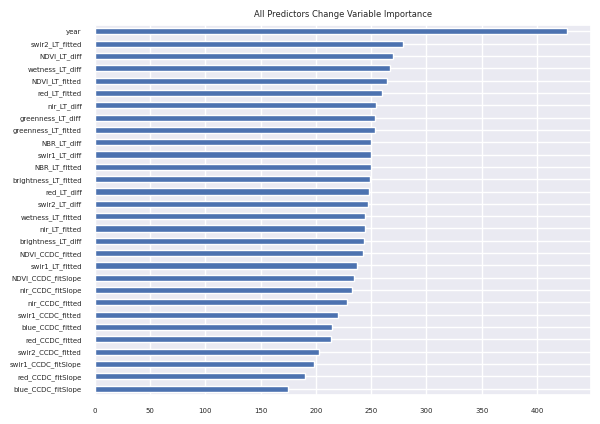

AttributeError: 'FeatureCollection' object has no attribute 'confusionMatrix'

In [179]:

# Not let's train similar models inside GEE to see the similarities and differences

# Set some parameters
top_n_variables = 30 # Take this number of variables into the final model
nTrees = 50

# Function to take GEE variable importance and make a pyplot barchart
def var_importance_plot(importance_dict,title = 'Variable Importance', n_variables = 30,descending = True):
    feature_importances = pd.Series(importance_dict.values(), index=importance_dict.keys())\
                            .sort_values(ascending=descending)\
                            .iloc[-n_variables:]
    feature_importances.plot.barh(title=title,fontsize=5);
    plt.show()
# Function to take GEE confusionMatrix object and make a Pandas dataframe from it
def formatConfusionMatrix(confusionMatrix,code_names):
    # Only make one call to GEE for the confusion matrix info
    cm_info = ee.Dictionary({
        'accuracy':confusionMatrix.accuracy(),
        'consumersAccuracy':confusionMatrix.consumersAccuracy(),
        'producersAccuracy':confusionMatrix.producersAccuracy(),
        'confusionMatrix':confusionMatrix
    }).getInfo()
    
    # Pull the overall accuracy (this is not from the out-of-bag samples, os is higher than the OOB accuracy
    overall_accuracy = int(cm_info['accuracy']*100)
    
    # Get the consumers accuracy and get rid of the 0 value (1 - commission error)
    consumers_accuracy = [int(i*100) for i in cm_info['consumersAccuracy'][0][1:]]
    consumers_accuracy.append(overall_accuracy)
    
    # Get the producers accuracy and get rid of the 0 value (1 - omission error)
    producers_accuracy = [int(i[0]*100) for i in cm_info['producersAccuracy'][1:]]
    
    # Pull in the confusion matrix (this uses all samples, so it is far more accurate than reality)
    confusionMatrix = cm_info['confusionMatrix']
    
    # Get rid of 0 value row and column (0 is not used for any LCMS output value)
    confusionMatrix = [row[1:] for row in confusionMatrix[1:]]
    
    # Append the producers and consumers accuracy
    confusionMatrix2 = []
    for i,row in enumerate(confusionMatrix):
        row.append(producers_accuracy[i])
        confusionMatrix2.append(row)
    confusionMatrix2.append(consumers_accuracy)
    
    # Give meaningful row and column names
    row_names = code_names.copy()
    col_names = code_names.copy()
    row_names.append('Consumers Accuracy (1 - commission error)')
    col_names.append('Producers Accuracy (1 - omission error)')
    
    # Show the confusion matrix
    display(pd.DataFrame(confusionMatrix2 ,index = row_names,columns = col_names))
    
# Function to get info from a GEE random forest model
def getModelInfo(model, code_names,title = ''):
    print('Getting model info for',title)
    
    
    importance = model.explain().get('importance').getInfo()
    OOB_accuraccy = 1- model.explain().get('outOfBagErrorEstimate').getInfo()
    
    print(f'{title} OOB Accuracy: {OOB_accuraccy}')
    confusionMatrix = model.confusionMatrix()
    formatConfusionMatrix(confusionMatrix,code_names)
    
    # Get the variable importance plot
    return var_importance_plot(importance,title + ' Variable Importance')
    
rf_models = {}
def fit_rf(product_name):
    product_title = product_name.replace('_',' ')
    # Set up RF model 
    rf = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)

    # Fit the RF model using all predictors
    rf = rf.train(training_data, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    rf_models[product_name] = rf
    # Get model info
    code_names = lcms_viz_dict[f'{product_name}_class_names'][:-1]
    importance = getModelInfo(rf, code_names,f'All Predictors {product_title}')
    
    

    training = training_data.filter("random < 0.8")
    holdout = training_data.filter("random >= 0.8")
    rf2 = rf.train(training, reference_field_dict[product_name]['field']+'_Code', predictor_field_names)
    validation = holdout.classify(rf2,'predicted')
    # # print(validation.first().getInfo())
    confusionMatrix = validation.confusionMatrix(reference_field_dict[product_name]['field']+'_Code', "predicted")
    formatConfusionMatrix(confusionMatrix,code_names)
    # print(errorMatrix.getInfo())

    
    # predicted = predictor_stack.classify(rf,product_name).set(lcms_viz_dict)

    # Map.addLayer(predicted,{'autoViz':True},f'All Predictors {product_title} {apply_year}')
training_data = training_data.randomColumn(seed=seed)
for product in ['Land_Cover','Land_Use','Change'][-1:]:
    fit_rf(product)
# print(training_data.size().getInfo())
# Notice the out-of-bag accuracy is roughly the same as in scikit-learn random forest

# # importance = var_importance_plot(rf_lc_info['importance'],'Land Cover All Variables')
# rf_lc = ee.Classifier.smileRandomForest(numberOfTrees = nTrees, variablesPerSplit = None, minLeafPopulation = 1, bagFraction = 0.5, maxNodes = None, seed = seed)
# lc_predictor_field_names =  list(importance.keys())
# rf_lc = rf_lc.train(training_data, reference_field_dict['Land_Cover']['field']+'_Code',lc_predictor_field_names)#['NBR_LT_fitted'])
# # importance = rf_lc.explain().get('importance').getInfo()
# getModelInfo(rf_lc, lcms_viz_dict['Land_Cover_class_names'][:-1],f'Top {top_n_variables} Variables Land Cover')
# # var_importance_plot(importance,f'Land Cover Top {top_n_variables}')


# lc_predicted = predictor_stack.classify(rf_lc,'Land_Cover').set(lcms_viz_dict)
# # # print(lc_predicted.bandNames().getInfo())
# Map.addLayer(lc_predicted,{'autoViz':True},f'Land Cover Top {top_n_variables}')
# Map.turnOnInspector()
# Map.view()

# Notice that there is quite a bit omission error in fast loss even for the training samples. 
# This means the omission error is likely much higher in reality

In [365]:
# For change, we have found that simply taking the class the model is most confident of yields a 
# high rate of omission
# This is likely because we have far more stable plots than change plots
# To remedy this, we look for a threshold of model vote proportion (number of trees that classified the plot as yes)
# that balances omission and commission
# The result from this step is then used later in the map assemblage

nTrees=150

product_name = 'Change'

# First set up a the predictor and reference field names
model_options_df = model_options_df[model_options_df['Model Name'] == 'Non-correlated Predictors Top 30']

# Pull the predictor variables from the prior exercise
predictor_variable_names = model_options_df[model_options_df['Product Name'] == product_name]['Var Imp'].values[0]

code_field_name = reference_field_dict[product_name]['field']+'_Code'

# Split the training data as we did before into dependent (y) and independent (X) variables
X = training_df[predictor_variable_names]
y = training_df[code_field_name]

# Split them into a test and train set for further model evaluation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Set up a random forest model
print('Fitting models for thresholding')
rf_all = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)
rf_holdout = RandomForestClassifier(n_estimators = nTrees, random_state=seed,oob_score=True,)

# Fit using all training as well as the holdout
rf_all = rf_all.fit(X,y)
rf_holdout = rf_holdout.fit(X_train,y_train)

# Apply the model and get the proportion of votes for each class
rf_all_probs = rf_all.predict_proba(X)
rf_holdout_probs = rf_holdout.predict_proba(X_test)


print('Done')

Fitting models for thresholding
Done


Stable 1


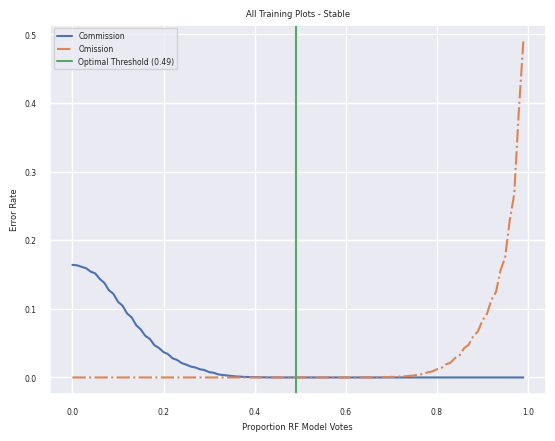

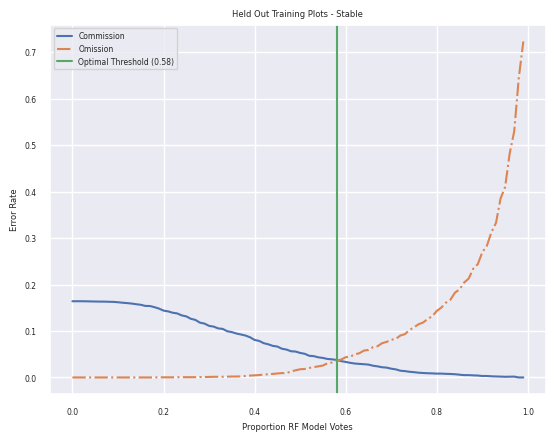

Slow Loss 2


/var/tmp/ipykernel_15057/2829746015.py:22: RuntimeWarning: invalid value encountered in long_scalars
  commission.append(sum(fp)/sum(pred_positive))


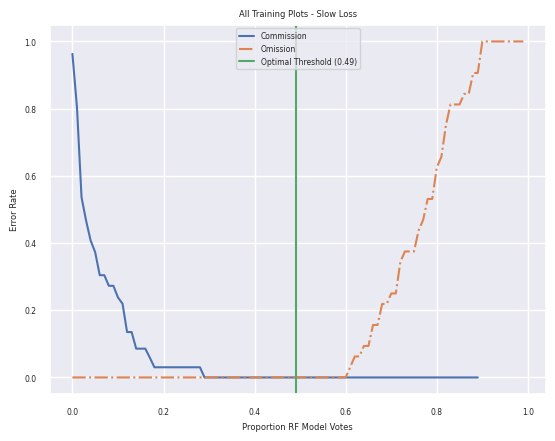

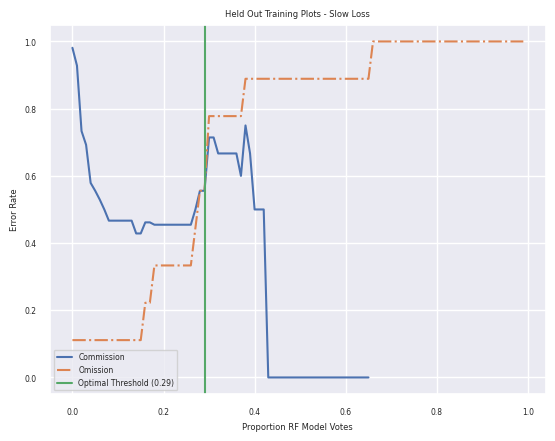

Fast Loss 3


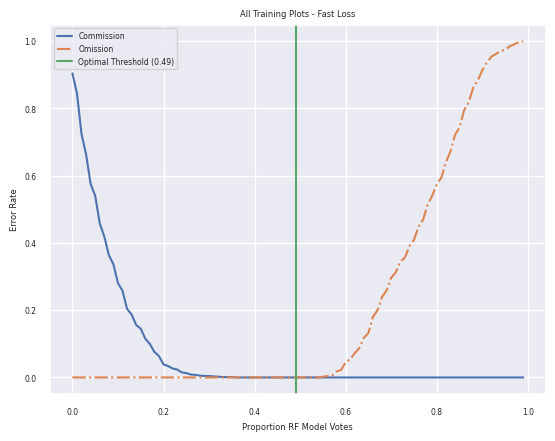

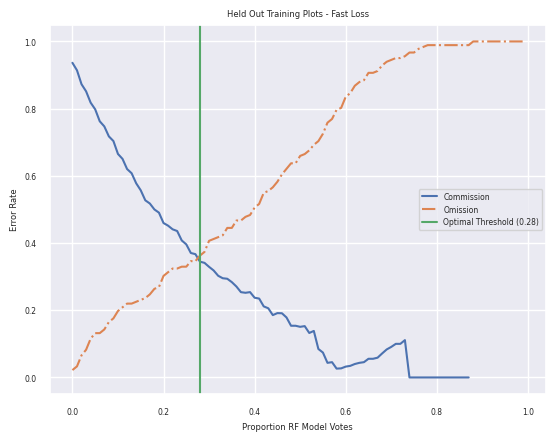

Gain 4


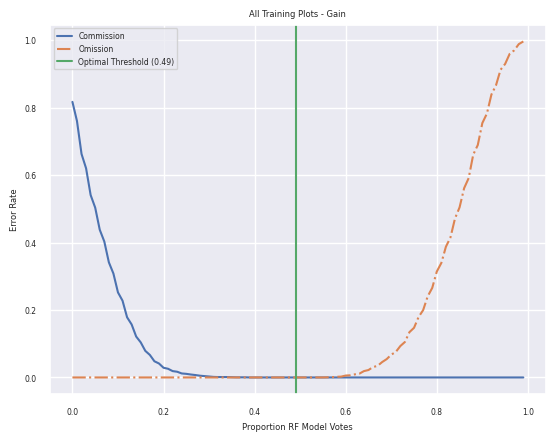

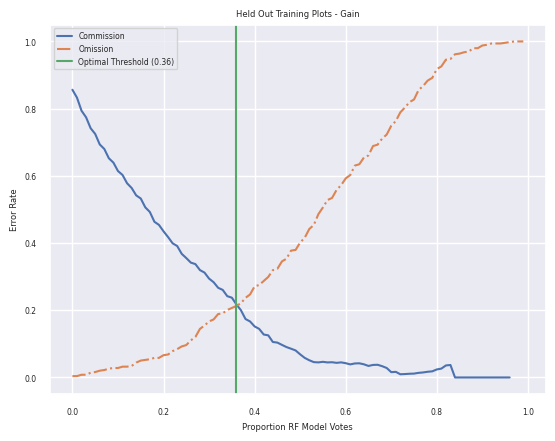

{'Stable': 0.58, 'Slow Loss': 0.29, 'Fast Loss': 0.28, 'Gain': 0.36}
{'Stable': 0.58, 'Slow Loss': 0.29, 'Fast Loss': 0.28, 'Gain': 0.36}
Done


In [379]:
# Next we'll compute the proportion of votes that balances omission and commission

# Specify individual class names and codes for change
change_class_codes = {'Stable':1,'Slow Loss':2,'Fast Loss':3,'Gain':4}

# Make a function that will take a list of binary reference and probablity (0-1 float) 
# predicted values and find the optimal threshold to balance omission and commission
def getBalancedThreshold(y_ref_binary,y_pred_probs,title='Omission-Commission Error',thresholds = list(np.arange(0,1,0.01))):
    
    omission = []
    commission = []
    
    # Iterate across each threshold and compute the omission and commision error rates
    for threshold in thresholds:
        
        y_pred_binary = np.where(y_pred_probs>threshold, 1, 0)
        fp = (y_pred_binary == 1) & (y_ref_binary == 0) 
        pred_positive = y_pred_binary == 1
        ref_positive = y_ref_binary == 1
        fn = (y_pred_binary == 0) & (y_ref_binary == 1) 
        tp = (y_pred_binary == 1) & (y_ref_binary == 1) 
        commission.append(sum(fp)/sum(pred_positive))
        omission.append(sum(fn)/sum(ref_positive))
    
    # Find the threshold that corresponds to the smallest difference between omission and commission
    diff = np.abs(np.array(omission)-np.array(commission))
    diff = np.stack((thresholds,diff),1)
    diff = diff[diff[:, 1].argsort()]
    optimal_thresh = diff[0][0]
    
    # Plot the curves
    plt.plot(thresholds, commission,label='Commission')
    plt.plot(thresholds,omission, '-.',label='Omission')
    plt.axvline(x = optimal_thresh, color = 'g', label = f'Optimal Threshold ({optimal_thresh})')
    plt.xlabel("Proportion RF Model Votes")
    plt.ylabel("Error Rate")
    plt.title(title)
    plt.legend()
    plt.show()
    
    
    return optimal_thresh

# Iterate across each class and find the optimal threshold
out_threshold_dict = {}
for change_class,change_code in list(change_class_codes.items()):
    print(change_class,change_code)
    y_pred_prob_rf_all =rf_all_probs[:,change_code-1]
    y_pred_prob_rf_holdout =rf_holdout_probs[:,change_code-1]
    
    y_ref_binary = np.where(y==change_code, 1, 0)
    y_test_binary = np.where(y_test==change_code,1,0)
    rf_all_thresh = getBalancedThreshold(y_ref_binary,y_pred_prob_rf_all,f'All Training Plots - {change_class}')
    rf_holdout_thresh = getBalancedThreshold(y_test_binary,y_pred_prob_rf_holdout,f'Held Out Training Plots - {change_class}')
    out_threshold_dict[change_class] = rf_holdout_thresh

print(out_threshold_dict)

# Save table for use in notebook 5.2
model_options_csv_filename = os.path.join(local_model_data_folder,'LCMS_change_thresholds.csv')
o = open(model_options_csv_filename,'w')
o.write(json.dumps(out_threshold_dict))
o.close()

o = open(model_options_csv_filename,'r')
threshs = json.load(o)
o.close()
print(threshs)

print('Done')